In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from models import BDRE, MDRE, TPE
from botorch import fit_gpytorch_mll
from botorch.optim.optimize import optimize_acqf
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.utils.transforms import unnormalize, normalize


N_DIMS = 1 # Number of dimensions
NUM_SAMPLES = 10 # Number of samples per distribution (if 3 distributions, then 3 x 33000)
BS = 64 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 42
GAMMA = 1 / 3
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
#     f = (6*x - 2)**2 * np.sin(3*x - 4)
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return f

In [4]:
dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
dense_y = forrester(dense_x, noise=False)

In [5]:
X_obs = np.random.uniform(-1, 2, (10, 1))
y_obs = forrester(X_obs, noise=True)
tau = np.quantile(y_obs, q=GAMMA)

In [6]:
def split_good_bad(X, y, gamma):
    tau = np.quantile(np.unique(y), q=gamma)
    z = np.less(y, tau).flatten()

    return X, y, z, tau

In [7]:
from botorch.utils.sampling import draw_sobol_samples

def prepare_data_bdre(X_obs, y_obs, gamma):
    X_obs = torch.tensor(X_obs, **tkwargs)
    y_obs = torch.tensor(y_obs, **tkwargs)

    tau = torch.quantile(y_obs, q=gamma)
    z_obs = torch.less(y_obs, tau).flatten()

    x_p, y_p = X_obs[z_obs], y_obs[z_obs]
    w_p = (tau - y_obs)[z_obs]
    w_p = w_p / torch.mean(w_p)
    z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)

    x_q, y_q = X_obs[~z_obs], y_obs[~z_obs]
    w_q = torch.empty(x_q.shape[0], 1, dtype=X_obs.dtype).fill_(1)
    z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)

    x_train = torch.cat([x_p, x_q], axis=0)
    y_train = torch.cat([y_p, y_q], axis=0)
    z = torch.cat([z_p, z_q], axis=0)
    z_train = torch.nn.functional.one_hot(z).to(X_obs.dtype)
    w_train = torch.cat([w_p, w_q], axis=0)
    w_train = w_train / w_train.mean()
    return x_train, y_train, z_train, w_train, tau

def prepare_data_mdre(X_obs, y_obs, gamma):
    X_obs = torch.tensor(X_obs, **tkwargs)
    y_obs = torch.tensor(y_obs, **tkwargs)

    tau = torch.quantile(y_obs, q=gamma)
    z_obs = torch.less(y_obs, tau).flatten()

    x_p, y_p = X_obs[z_obs], y_obs[z_obs]
    x_q, y_q = X_obs[~z_obs], y_obs[~z_obs]
    x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]]), n=int(len(x_p)), q=1).squeeze(1)
    y_m = forrester(x_m, noise=False)

    z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
    z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
    z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)

    s_p = x_p.shape[0]
    s_q = x_q.shape[0]
    s_m = x_m.shape[0]

    w_p = (tau - y_obs)[z_obs].squeeze(1)
#     w_p = w_p / torch.mean(w_p)
    w_p = w_p * (s_p + s_q + s_m) / s_p
    w_q = z_q * (s_p + s_q + s_m) / s_q
    w_m = torch.tensor(len(z_m) * [ (s_q + s_p + s_m) / s_m]).to(X_obs.dtype)

    x_train = torch.cat([x_p, x_q, x_m], axis=0)
    y_train = torch.cat([y_p, y_q, y_m], axis=0)
    z = torch.cat([z_p, z_q, z_m], axis=0)
    z_train = torch.nn.functional.one_hot(z).to(X_obs.dtype)
    w_train = torch.cat([w_p, w_q, w_m], axis=0)
    w_train = w_train / w_train.mean()
    return x_train, y_train, z_train, w_train, tau

In [8]:
def plot_step_through_tpe(X_obs, y_obs, z_obs, new_x, new_y, tau, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    # tpe
    x_p = X_obs[z_obs]
    y_p = y_obs[z_obs]
    x_q = X_obs[~z_obs]
    y_q = y_obs[~z_obs]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('TPE')

    good_density = np.exp(tpe.kde_good.score_samples(dense_x))
    bad_density = np.exp(tpe.kde_bad.score_samples(dense_x))
    ax_func.fill_between(
        dense_x.flatten(),
        good_density,
        0,
        facecolor="#d627283f",
        edgecolor="#d62728",
        label=r"$\ell(x)$",
    )
    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    
    ax_func.fill_between(
        dense_x.flatten(),
        bad_density,
        0,
        facecolor="#1f77b43f",
        edgecolor="#1f77b4",
        label=r"$g(x)$",
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
#     ax_func.legend()

    ax_acf.fill_between(
        dense_x.flatten(),
        acf,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

    
def plot_step_through_bdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]

    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('BDRE')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )

    ax_acf.fill_between(
        dense_x.flatten(),
        dr,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')


def plot_step_through_mdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]
    x_m = X_obs[z_obs[:, 2].bool()]
    
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 2], s=1, color='tab:green',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('MDRE')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
    ax_func.plot(
        x_m,
        np.zeros(len(x_m)),
        '|',
        markersize=12,
        color="tab:green"
    )

    ax_acf.fill_between(
        dense_x.flatten(),
        dr,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

def plot_step_through_lfbo(X_obs, y_obs, new_x, new_y, acf_mean, acf_samples, ax_func, ax_acf):
    X_obs_rff, y_obs_rff, z_obs_rff, tau = split_good_bad(X_obs, y_obs, gamma=GAMMA)
    acf_std = torch.std(acf_samples, axis=0).numpy()

    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs_rff[z_obs_rff]
    y_p = y_obs_rff[z_obs_rff]
    x_q = X_obs_rff[~z_obs_rff]
    y_q = y_obs_rff[~z_obs_rff]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    # ax_func.scatter(dense_x, acf_mean + 2 * acf_std, s=1, color='tab:red',)
    # ax_func.scatter(dense_x, 1-acf_samples, s=1, color='tab:blue',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('LFBO_RFF')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
    ax_acf.plot(
        dense_x,
        acf_mean.reshape(dense_x.shape),
        c='k',
        label="mean",
    )
    for n, posterior_sample in enumerate(acf_samples):
        ax_acf.plot(
            dense_x,
            posterior_sample.reshape(dense_x.shape),
            alpha=.6,
            label='posterior samples' if n<1 else None
        )
        if n > 5:
            break

    ax_acf.fill_between(
        dense_x.flatten(),
        (acf_mean+2*acf_std).ravel(),
        (acf_mean-2*acf_std).ravel(),
        color="tab:gray",
        alpha=0.3,
        label="confidence interval",
    )
    
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

100%|██████████| 500/500 [00:00<00:00, 898.38it/s]


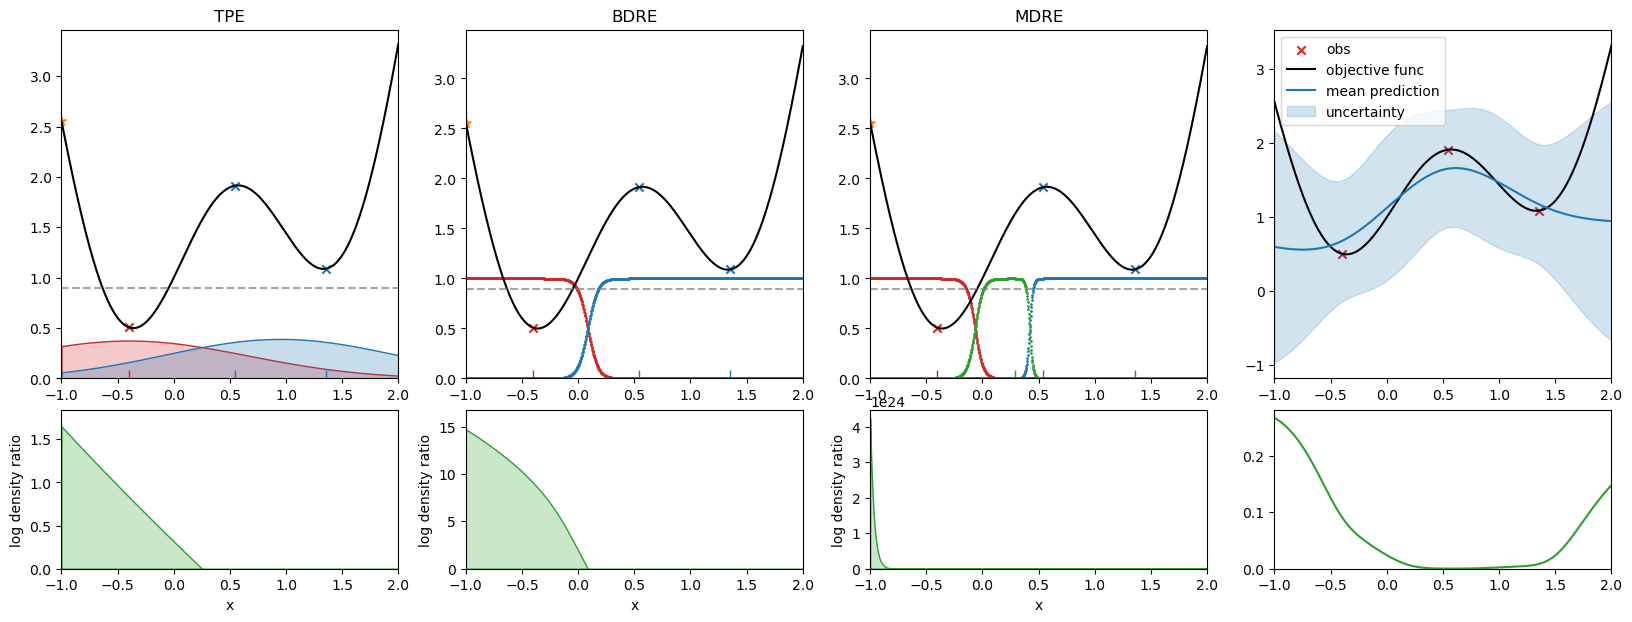

100%|██████████| 500/500 [00:00<00:00, 872.27it/s]


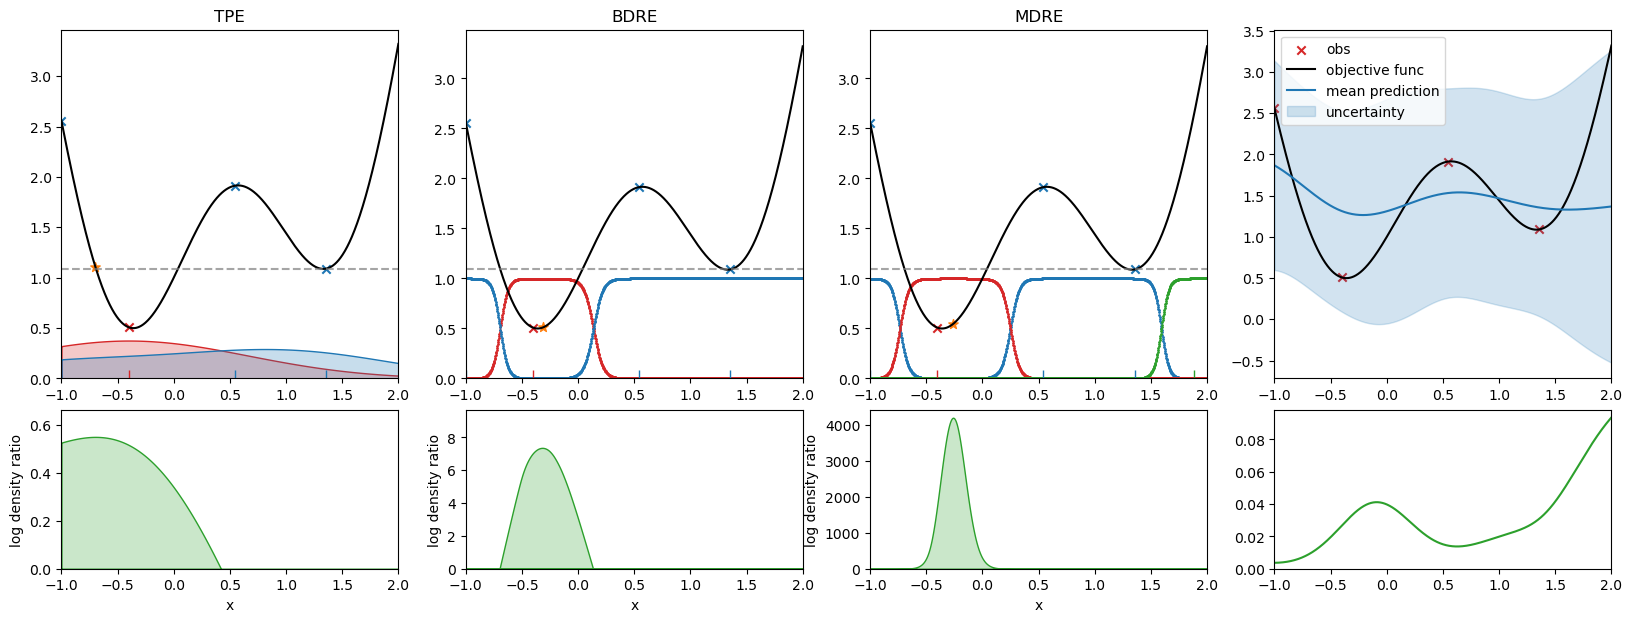

100%|██████████| 500/500 [00:00<00:00, 856.49it/s]


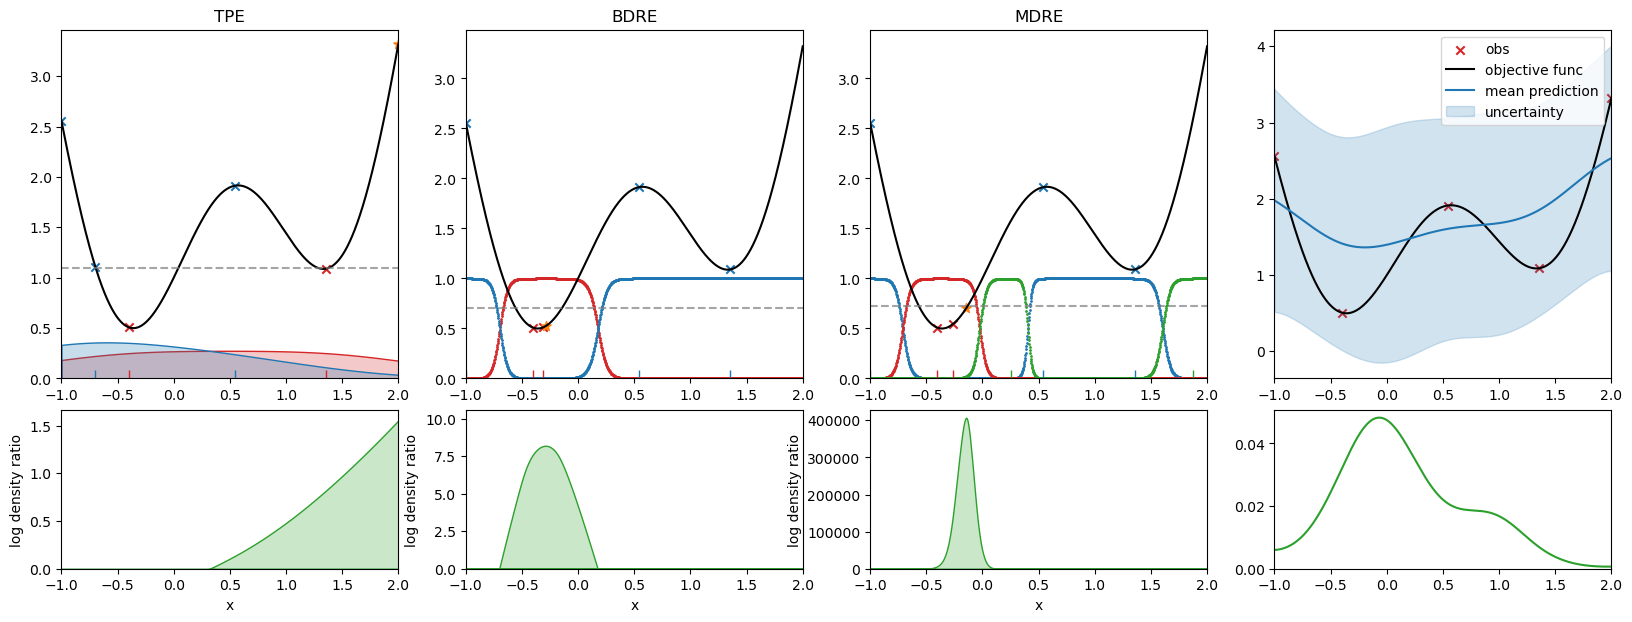

100%|██████████| 500/500 [00:00<00:00, 849.65it/s]


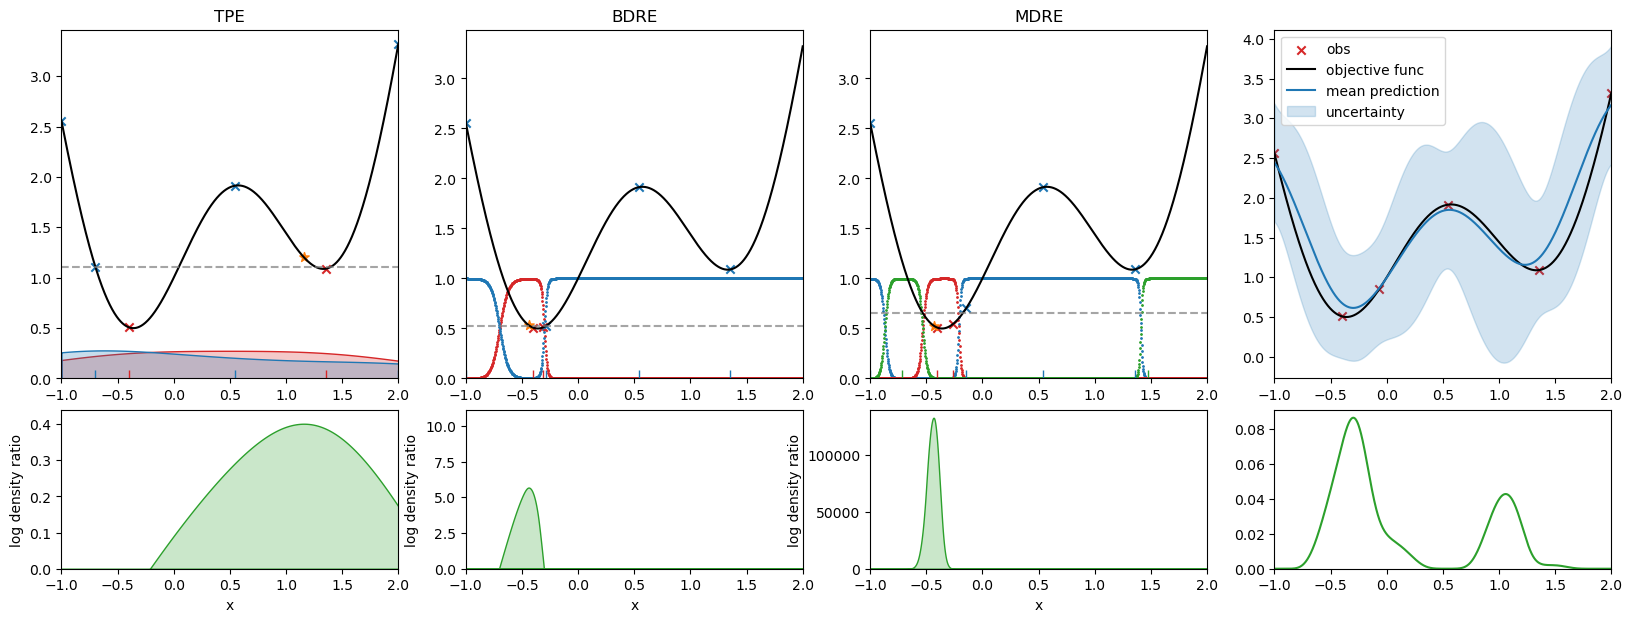

100%|██████████| 500/500 [00:00<00:00, 879.50it/s]


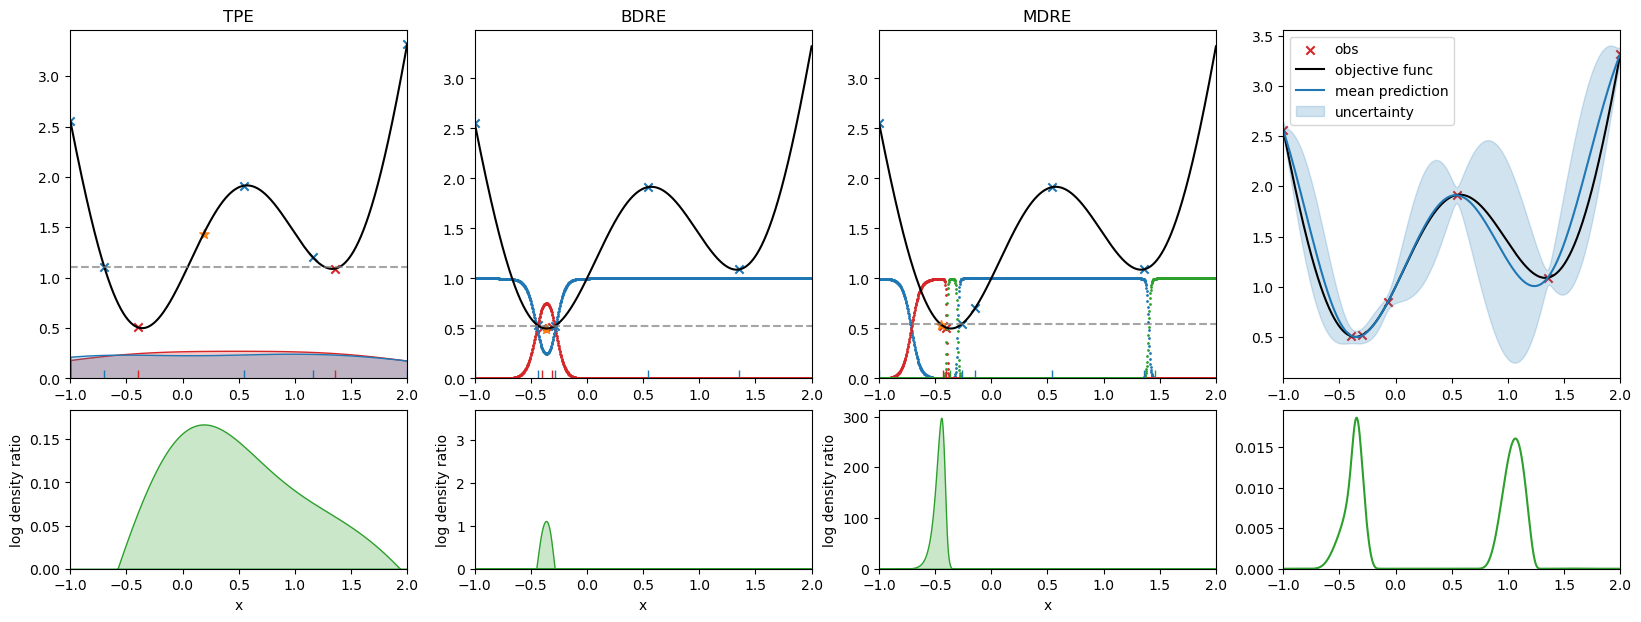

In [10]:
X_obs = np.random.uniform(-1, 2, (3,1))
y_obs = forrester(X_obs, noise=False)

X_obs_tpe, y_obs_tpe = X_obs, y_obs
X_obs_bdre, y_obs_bdre = X_obs, y_obs
X_obs_mdre, y_obs_mdre = X_obs, y_obs
X_obs_gp, y_obs_gp = torch.from_numpy(X_obs), torch.from_numpy(y_obs)

num_evaluations = 5
GAMMA = 1 / 3

for n in range(num_evaluations):
    
    fig = plt.figure(figsize=(20, 7))
    ax_func_tpe = plt.subplot2grid((3, 4), (0, 0), rowspan=2)
    ax_acf_tpe = plt.subplot2grid((3, 4), (2, 0), rowspan=1)
    ax_func_bdre = plt.subplot2grid((3, 4), (0, 1), rowspan=2)
    ax_acf_bdre = plt.subplot2grid((3, 4), (2, 1), rowspan=1)
    ax_func_mdre = plt.subplot2grid((3, 4), (0, 2), rowspan=2)
    ax_acf_mdre = plt.subplot2grid((3, 4), (2, 2), rowspan=1)
    ax_func_gp = plt.subplot2grid((3, 4), (0, 3), rowspan=2)
    ax_acf_gp = plt.subplot2grid((3, 4), (2, 3), rowspan=1)

    # tpe
    tpe = TPE(kernel='gaussian')
    X_obs_tpe, y_obs_tpe, z_obs_tpe, tau = split_good_bad(X_obs_tpe, y_obs_tpe, gamma=GAMMA)
    tpe.fit(X_obs_tpe, y_obs_tpe, z_obs_tpe)
    acf_tpe = tpe.predict(dense_x)
    new_x = dense_x[np.argmax(acf_tpe)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_tpe(X_obs_tpe, y_obs_tpe, z_obs_tpe, new_x, new_y, tau, acf_tpe, ax_func_tpe, ax_acf_tpe)
    X_obs_tpe = np.concatenate([X_obs_tpe, new_x.reshape(-1, 1)])
    y_obs_tpe = np.concatenate([y_obs_tpe, new_y.reshape(-1, 1)])

    # bdre
    # X_obs_bdre, y_obs_bdre, z_obs_bdre, tau = split_good_bad(X_obs_bdre, y_obs_bdre, gamma=GAMMA)
    X_train_bdre, y_train_bdre, z_train_bdre, bdre_weight, tau = prepare_data_bdre(X_obs_bdre, y_obs_bdre, gamma=GAMMA)
    bdre = BDRE(input_dim=1, output_dim=2, **tkwargs)
    bdre.fit(X_train_bdre, z_train_bdre, bdre_weight, S=500)
    bdre_preds = bdre.predict(torch.from_numpy(dense_x))
    dr_bdre = (bdre_preds[:, 0] - bdre_preds[:, 1]).numpy()
    acf_bdre = torch.nn.functional.softmax(bdre_preds, dim=-1).numpy()
    new_x = dense_x[np.argmax(dr_bdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_bdre(X_train_bdre, y_train_bdre, z_train_bdre, new_x, new_y, tau, dr_bdre, acf_bdre, ax_func_bdre, ax_acf_bdre)
    X_obs_bdre = np.concatenate([X_obs_bdre, new_x.reshape(-1, 1)])
    y_obs_bdre = np.concatenate([y_obs_bdre, new_y.reshape(-1, 1)])
    
    # mdre
    # X_obs_mdre, y_obs_mdre, z_obs_mdre, tau = split_good_bad(X_obs_mdre, y_obs_mdre, gamma=GAMMA)
    X_train_mdre, y_train_mdre, z_train_mdre, mdre_weight, tau = prepare_data_mdre(X_obs_mdre, y_obs_mdre, gamma=GAMMA)
    mdre = MDRE(input_dim=1, output_dim=3, **tkwargs)
    mdre.fit(X_train_mdre, z_train_mdre, mdre_weight, S=500)
    mdre_preds = mdre.predict(torch.from_numpy(dense_x))
    acf_mdre = torch.nn.functional.softmax(mdre_preds, dim=-1).numpy()
    dr_mdre = acf_mdre[:, 0] / acf_mdre[:, 1]
#     dr_mdre = (mdre_preds[:, 0] - mdre_preds[:, 1]).numpy()
    new_x = dense_x[np.argmax(dr_mdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_mdre(X_train_mdre, y_train_mdre, z_train_mdre, new_x, new_y, tau, dr_mdre, acf_mdre, ax_func_mdre, ax_acf_mdre)
    X_obs_mdre = np.concatenate([X_obs_mdre, new_x.reshape(-1, 1)])
    y_obs_mdre = np.concatenate([y_obs_mdre, new_y.reshape(-1, 1)])

    # gp
    bounds = torch.tensor([[-1.], [2.]])
    x_norm = normalize(X_obs_gp, bounds)
    # build a GP model scalarized objectives
    model = SingleTaskGP(
        x_norm, y_obs_gp, outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    x_dense = torch.from_numpy(dense_x).to(**tkwargs)
    with torch.no_grad():
        posterior = model.posterior(normalize(x_dense, bounds))
        mean_pred = posterior.mean
        std_pred = posterior.variance.sqrt()

    # define acquisition function
    acq_func = ExpectedImprovement(
        model=model,
        best_f=y_obs.min(),
        maximize=False
    )

    # optimize
    candidate, _ = optimize_acqf(
        acq_func,
        bounds=torch.tensor([[0.], [1.]]),
        q=1,
        num_restarts=5,
        raw_samples=512,
    )
    new_x = unnormalize(candidate.detach(), bounds=bounds)
    new_y = forrester(new_x, noise=False)

    ax_func_gp.scatter(X_obs_gp, y_obs_gp, color='tab:red', marker='x', label="obs")
    ax_func_gp.plot(x_dense, forrester(x_dense, noise=False), color='k', label="objective func")
    ax_func_gp.plot(x_dense, mean_pred, color='tab:blue', label="mean prediction")
    ax_func_gp.fill_between(
        x_dense.squeeze(),
        (mean_pred + 2*std_pred).squeeze(),
        (mean_pred - 2*std_pred).squeeze(),
        alpha=.2,
        color='tab:blue',
        label="uncertainty"
    )
    ax_func_gp.legend()
    ax_func_gp.set_xlim(*bounds.numpy())

    with torch.no_grad():
        acq_vals = acq_func(normalize(x_dense, bounds).unsqueeze(1))

    ax_acf_gp.plot(x_dense, acq_vals, color='tab:green', label="ei")
    ax_acf_gp.set_xlim(*bounds.numpy())
    ax_acf_gp.set_ylim(0, None)

    X_obs_gp = torch.concat([X_obs_gp, new_x.reshape(-1, 1)])
    y_obs_gp = torch.concat([y_obs_gp, new_y.reshape(-1, 1)])

    plt.show()